## ToDo

* Capture videos from tablet
* Modify demo to inference and annotate video frames
* Implement low pass filter
* Implement click detection

In [ ]:
import os
import os.path as osp
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from google.colab import drive
from torch.nn.parallel.data_parallel import DataParallel

drive.mount("/content/gdrive")
os.chdir("/content/gdrive/MyDrive/DLwPyTorchProject5/")
sys.path.insert(0, osp.join("InterHand2.6M", "main"))
sys.path.insert(0, osp.join("InterHand2.6M", "data"))
sys.path.insert(0, osp.join("InterHand2.6M", "comon"))

from config import cfg
from model import get_model
from utils.preprocessing import (
    generate_patch_image,
    load_img,
    load_skeleton,
    process_bbox,
    trans_point2d,
    transform_input_to_output_space,
)
from utils.vis import vis_3d_keypoints, vis_keypoints

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

model_dir = "./model"
model_path = osp.join(model_dir, "InterNet.pth.tar")
os.makedirs(model_dir, exist_ok=True)
if not os.path.isfile(model_path):
    #https://drive.google.com/file/d/1vXDJcDK_nCCQ5TUDrUFMmxgzeN492Nog/view?usp=sharing
    download_file_from_google_drive(
        id = "1vXDJcDK_nCCQ5TUDrUFMmxgzeN492Nog",
        destination = model_path
    )
!ls -lh {model_dir}

total 542M
-rw------- 1 root root 542M Apr  5 18:02 InterNet.pth.tar


In [ ]:
# argument parsing
cfg.set_args("0")
cudnn.benchmark = True

# joint set information is in annotations/skeleton.txt
joint_num = 21 # single hand
root_joint_idx = {'right': 20, 'left': 41}
joint_type = {'right': np.arange(0,joint_num), 'left': np.arange(joint_num,joint_num*2)}
skeleton = load_skeleton("InterHand2.6M/data/InterHand2.6M/annotations/skeleton.txt", joint_num*2)

# snapshot load
assert osp.exists(model_path), 'Cannot find model at ' + model_path
print('Load checkpoint from {}'.format(model_path))
model = get_model('test', joint_num)
model = DataParallel(model).cuda()
ckpt = torch.load(model_path)
model.load_state_dict(ckpt['network'], strict=False)
model.eval()

>>> Using GPU: 0
Load checkpoint from ./model/InterNet.pth.tar


DataParallel(
  (module): Model(
    (backbone_net): BackboneNet(
      (resnet): ResNetBackbone(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, af

In [ ]:
# prepare input image
transform = transforms.ToTensor()
img_path = "input/tremor.jpg"
original_img = cv2.imread(img_path)
original_img_height, original_img_width = original_img.shape[:2]

# prepare bbox
bbox = [20, 270, 256, 370] # xmin, ymin, width, height
bbox = process_bbox(bbox, (original_img_height, original_img_width, original_img_height))
img, trans, inv_trans = generate_patch_image(original_img, bbox, False, 1.0, 0.0, cfg.input_img_shape)
img = transform(img.astype(np.float32))/255
img = img.cuda()[None,:,:,:]

In [ ]:
# forward
inputs = {'img': img}
targets = {}
meta_info = {}
with torch.no_grad():
    out = model(inputs, targets, meta_info, 'test')
img = img[0].cpu().numpy().transpose(1,2,0) # cfg.input_img_shape[1], cfg.input_img_shape[0], 3
joint_coord = out['joint_coord'][0].cpu().numpy() # x,y pixel, z root-relative discretized depth
rel_root_depth = out['rel_root_depth'][0].cpu().numpy() # discretized depth
hand_type = out['hand_type'][0].cpu().numpy() # handedness probability

In [ ]:
# restore joint coord to original image space and continuous depth space
joint_coord[:,0] = joint_coord[:,0] / cfg.output_hm_shape[2] * cfg.input_img_shape[1]
joint_coord[:,1] = joint_coord[:,1] / cfg.output_hm_shape[1] * cfg.input_img_shape[0]
joint_coord[:,:2] = np.dot(inv_trans, np.concatenate((joint_coord[:,:2], np.ones_like(joint_coord[:,:1])),1).transpose(1,0)).transpose(1,0)
joint_coord[:,2] = (joint_coord[:,2]/cfg.output_hm_shape[0] * 2 - 1) * (cfg.bbox_3d_size/2)

# restore right hand-relative left hand depth to continuous depth space
rel_root_depth = (rel_root_depth/cfg.output_root_hm_shape * 2 - 1) * (cfg.bbox_3d_size_root/2)

# right hand root depth == 0, left hand root depth == rel_root_depth
joint_coord[joint_type['left'],:] += rel_root_depth

# handedness
joint_valid = np.zeros((joint_num*2), dtype=np.float32)
right_exist = False
if hand_type[0] > 0.5: 
    right_exist = True
    joint_valid[joint_type['right']] = 1
left_exist = False
#if hand_type[1] > 0.5:
#    left_exist = True
#    joint_valid[joint_type['left']] = 1

print('Right hand exist: ' + str(right_exist) + ' Left hand exist: ' + str(left_exist))

Right hand exist: True Left hand exist: False


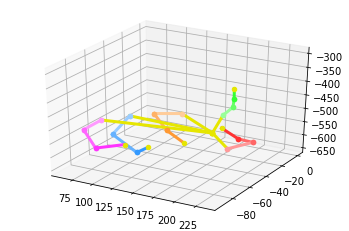

In [ ]:
# visualize joint coord in 2D space
save_dir = "output/vis"
filename = "tremor_2d.jpg"
vis_img = original_img.copy()[:,:,::-1].transpose(2,0,1)
vis_img = vis_keypoints(vis_img, joint_coord, joint_valid, skeleton, filename, save_path=save_dir)

# visualize joint coord in 3D space
# The 3D coordinate in here consists of x,y pixel and z root-relative depth.
# To make x,y, and z in real unit (e.g., mm), you need to know camera intrincis and root depth.
# The root depth can be obtained from RootNet (https://github.com/mks0601/3DMPPE_ROOTNET_RELEASE)
filename3d = 'tremor_3d'
vis_3d_keypoints(joint_coord, joint_valid, skeleton, filename3d)

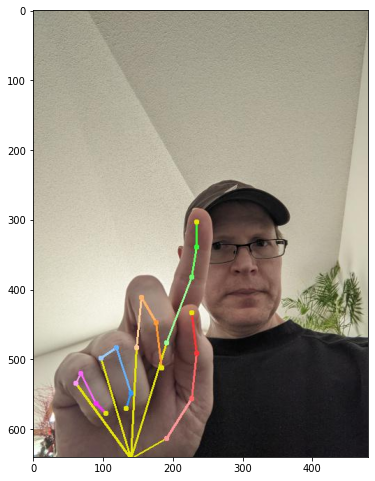

In [ ]:
#show the output image
result_path = osp.join(save_dir, filename)
result_img = cv2.imread(result_path)
result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,10))
plt.imshow(result_img)
plt.show()